In [1]:
!pip install torch torchvision timm numpy matplotlib tqdm scikit-learn

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

2024-05-30 19:35:51.309920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 19:35:51.310013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 19:35:51.434408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [3]:
import os
import urllib.request
import tarfile
import numpy as np
import torch
import torch.nn as nn
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader , random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time

In [4]:
!mkdir -p ./pretrained_weights/vit_base_patch16_224.augreg2_in21k_ft_in1k
!mv /kaggle/input/timmvit-base-patch16-224-augreg2-in21k-ft-in1k/pytorch_model.bin ./pretrained_weights/vit_base_patch16_224.augreg2_in21k_ft_in1k/


mv: cannot remove '/kaggle/input/timmvit-base-patch16-224-augreg2-in21k-ft-in1k/pytorch_model.bin': Read-only file system


In [5]:
dataset_path = '../input/CUB-200-2011'

In [10]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=28),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Loading the dataset using ImageFolder from torchvision.datasets
dataset = ImageFolder(root='/kaggle/input/cub2002011/CUB_200_2011/images', transform=train_transforms)

In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
val_dataset.dataset.transform = val_transforms

In [14]:
# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [15]:
print("Training dataset size : ", len(train_dataset))
print("Validation dataset size : ", len(val_dataset))

Training dataset size :  9436
Validation dataset size :  2360


In [16]:
class ViTAttention(nn.Module):
    def __init__(self, in_channels, num_classes, pretrained=True):
        super(ViTAttention, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=False)
        
        if pretrained:
            self.model.load_state_dict(torch.load('/kaggle/input/timmvit-base-patch16-224-augreg2-in21k-ft-in1k/pytorch_model.bin'))
        

        # Modify the last layer for fine-grained classification
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, num_classes)

        # Add attention mechanisms
        self.attention1 = SelfAttention(num_features)
        self.attention2 = HierarchicalAttention(num_features)

    def forward(self, x):
        features = self.model.forward_features(x)

        # Apply attention mechanisms
        attention1 = self.attention1(features)
        attention2 = self.attention2(features)

        # Concatenate attention features
        features = torch.cat((features, attention1, attention2), dim=1)

        # Pass through the final classifier
        output = self.model.head(features)

        return output

class SelfAttention(nn.Module):
    def __init__(self, num_features):
        super(SelfAttention, self).__init__()
        self.num_features = num_features
        self.query = nn.Linear(num_features, num_features)
        self.key = nn.Linear(num_features, num_features)
        self.value = nn.Linear(num_features, num_features)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, features):
        queries = self.query(features)
        keys = self.key(features)
        values = self.value(features)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / (self.num_features ** 0.5)
        attention_weights = self.softmax(attention_scores)

        attention_output = torch.matmul(attention_weights, values)

        return attention_output

class HierarchicalAttention(nn.Module):
    def __init__(self, num_features):
        super(HierarchicalAttention, self).__init__()
        self.attention1 = SelfAttention(num_features)
        self.attention2 = SelfAttention(num_features)

    def forward(self, features):
        attention1 = self.attention1(features)
        attention2 = self.attention2(attention1)

        return attention2

In [17]:
import os

# Create a directory to store the checkpoints
checkpoint_dir = '/kaggle/working/saved_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [18]:

# Instantiate your model architecture
model = ViTAttention(in_channels=3, num_classes=200, pretrained=True)

# Add dropout layers to the model architecture
model.attention1 = nn.Sequential(
    model.attention1,
    nn.Dropout(0.5)
)
model.attention2 = nn.Sequential(
    model.attention2,
    nn.Dropout(0.5)
)

# Define the loss function with L2 regularization
criterion = nn.CrossEntropyLoss()

# Set up the optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Set up the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the desired device
model.to(device)

# Load the last saved checkpoint if available
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('model_epoch_')])
if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    checkpoint_path = os.path.join(checkpoint_dir, last_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    print(f'Loaded checkpoint from epoch {start_epoch - 1}')
else:
    start_epoch = 0
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

# # Wrap the model with DataParallel if multiple GPUs are available
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
    
num_epochs = 20
start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        outputs = outputs.mean(dim=1)

        loss = criterion(outputs, labels.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += images.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}')
    
    end_time = time.time()
    


    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total_samples = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outputs = outputs.mean(dim=1)
            loss = criterion(outputs, labels.long())

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_total_samples += images.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_epoch_loss = val_loss / val_total_samples
    val_epoch_acc = val_corrects.double() / val_total_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=1)
    val_recall = recall_score(val_labels, val_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} - Val Precision: {val_precision:.4f} - Val Recall: {val_recall:.4f} - Val F1: {val_f1:.4f}')
    
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} time: {epoch_time:.2f} seconds")
    start_time = end_time
    
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
        if isinstance(model, nn.DataParallel):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, checkpoint_path)
        else:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, checkpoint_path)
        print(f'Model checkpoint saved for epoch {epoch+1}')
    
    # Update the learning rate scheduler with validation loss
    scheduler.step(val_epoch_loss)
    
    model_path = '/kaggle/working/final_model.pth'
    
    # Save the model checkpoint
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), model_path)
        else:
            torch.save(model.state_dict(), model_path)




Epoch 1/20 - Train Loss: 2.0405 - Train Acc: 0.5253
Epoch 1/20 - Val Loss: 1.0446 - Val Acc: 0.7097 - Val Precision: 0.7775 - Val Recall: 0.7125 - Val F1: 0.7000
Epoch 1 time: 187.94 seconds
Epoch 2/20 - Train Loss: 0.6333 - Train Acc: 0.8172
Epoch 2/20 - Val Loss: 1.0322 - Val Acc: 0.7263 - Val Precision: 0.7754 - Val Recall: 0.7293 - Val F1: 0.7207
Epoch 2 time: 206.39 seconds
Epoch 3/20 - Train Loss: 0.3712 - Train Acc: 0.8876
Epoch 3/20 - Val Loss: 1.0876 - Val Acc: 0.7182 - Val Precision: 0.7747 - Val Recall: 0.7234 - Val F1: 0.7109
Epoch 3 time: 204.28 seconds
Epoch 4/20 - Train Loss: 0.2563 - Train Acc: 0.9241
Epoch 4/20 - Val Loss: 1.1300 - Val Acc: 0.7123 - Val Precision: 0.7455 - Val Recall: 0.7200 - Val F1: 0.7086
Epoch 4 time: 203.53 seconds
Epoch 5/20 - Train Loss: 0.2071 - Train Acc: 0.9396
Epoch 5/20 - Val Loss: 1.2434 - Val Acc: 0.7064 - Val Precision: 0.7492 - Val Recall: 0.7117 - Val F1: 0.7059
Epoch 5 time: 203.68 seconds
Epoch 6/20 - Train Loss: 0.1948 - Train Acc: 

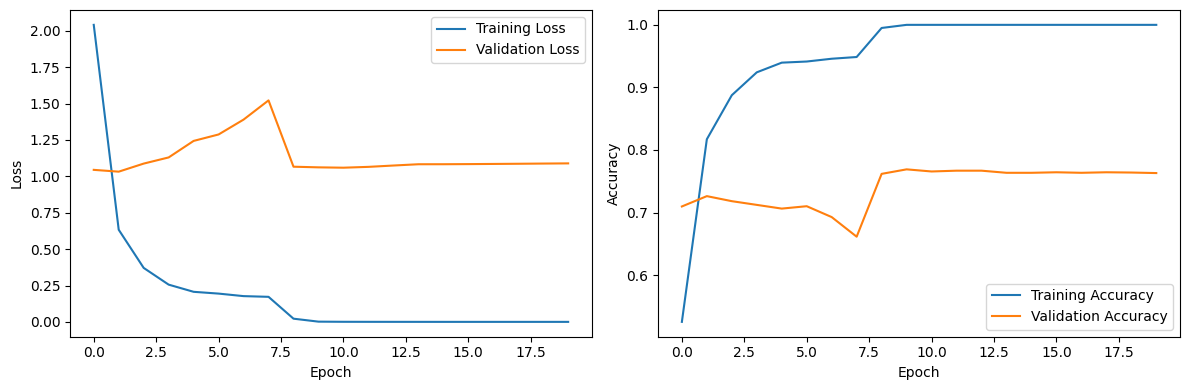

In [21]:
# Plot training and validation losses and accuracies

# Move the tensors to CPU for plotting
train_accuracies_cpu = [acc.cpu().item() for acc in train_accuracies]
val_accuracies_cpu = [acc.cpu().item() for acc in val_accuracies]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
# import os -> os.chdir(r'/kaggle/working') 
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_cpu, label='Training Accuracy')
plt.plot(val_accuracies_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
%ls

__notebook__.ipynb  final_model.pth  pretrained_weights/  saved_checkpoints/
